# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch.optim as optim
import torch
import torch.nn as nn

from pytorch_model import FCNet
from pytorch_trainer import Trainer
from pytorch_dataloader import NumberDataLoader


%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [2]:
loader = NumberDataLoader()
train_loader, val_loader = loader.get_data_loaders(batch_size=32, num_workers=0)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [3]:
sample, label = loader.data_train[0]
print("SVHN data sample shape: ", sample.shape)
print("SVHN data label : ", label)
# As you can see, the data is shaped like an image

SVHN data sample shape:  torch.Size([3, 32, 32])
SVHN data label :  1


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [4]:
def accuracy(predictions, labels):
    indices = torch.argmax(predictions, dim=1)
    correct_samples = torch.sum(indices == labels)
    total_samples = len(labels)
    
    return float(correct_samples) / total_samples

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

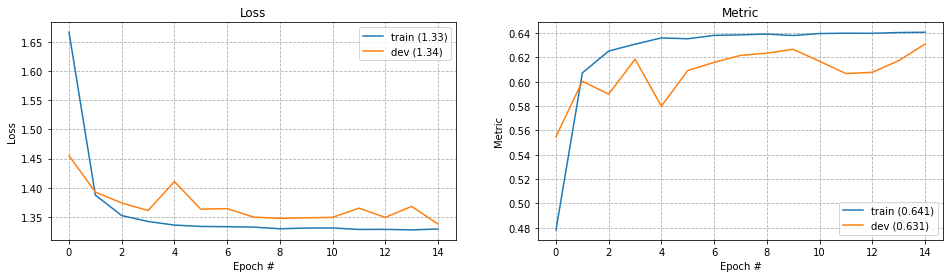

In [21]:
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[100], 
                 batch_norm=False).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=15)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

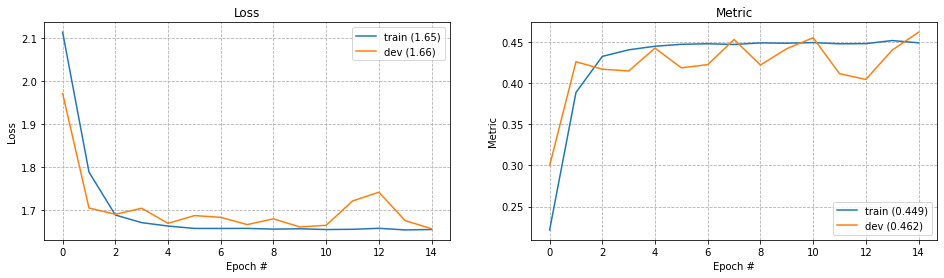

In [22]:
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[100, 100], 
                 batch_norm=False).type(torch.FloatTensor)


trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=15)

Добавьте слой с Batch Normalization

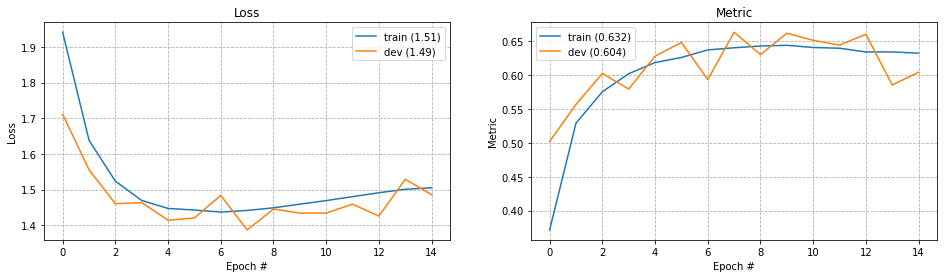

In [34]:
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[100, 100], 
                 batch_norm=True).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=15)

Добавьте уменьшение скорости обучения по ходу тренировки.

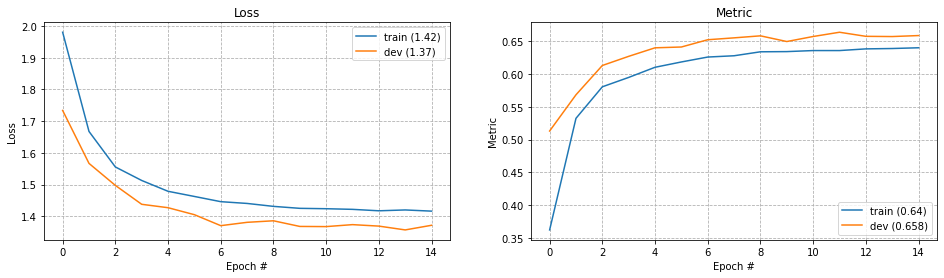

In [9]:
# weight_decay == L2 regularization
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[100, 100], 
                 batch_norm=True).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.5)


trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device,
              scheduler=scheduler,
              epochs=15)


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
from torch.utils.data.sampler import Sampler
import numpy as np


class SubsetSampler(Sampler):
    def __init__(self, indices: np.array):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices, device):
    model.eval() # Evaluation mode
    
    with torch.no_grad():
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices),
                                             sampler=SubsetSampler(indices))
        
        for i, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)
            model_prediction = model(x)
            number_predictions = torch.argmax(model_prediction, dim=1)
            ground_truth = y
                                                  
    return number_predictions.detach().cpu().numpy(), ground_truth.detach().cpu().numpy()

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

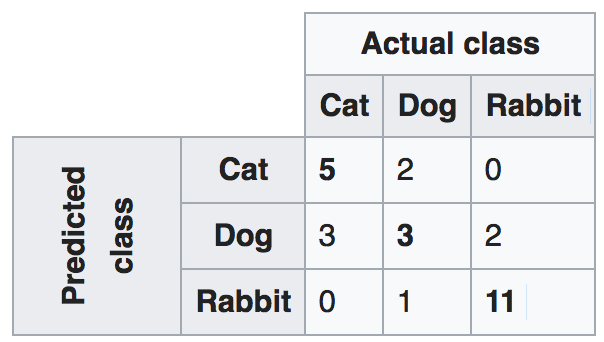

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_confusion_matrix(confusion_matrix: np.array):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions: np.array, ground_truth: np.array) -> np.array:
    
    confusion_matrix = np.zeros((10,10), np.int)
    for i in range(0, 10):
        for j in range(0, 10):
            current_number_pred = np.where(predictions == i)
            predicted_cnt = np.sum(ground_truth[current_number_pred] == j)
            confusion_matrix[i, j] = predicted_cnt
            
    return confusion_matrix

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

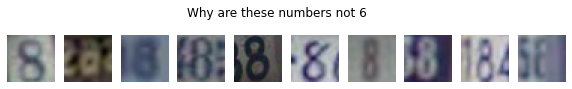

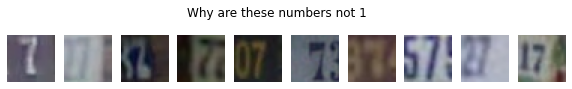

In [29]:
import torchvision.datasets as dset

data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    indices = np.where((predictions == predicted_class) & (groud_truth == gt_class))
    visualize_images(val_indices[indices], data, title=f"Why are these numbers not {predicted_class}")
    
visualize_predicted_actual(6, 8, predictions, gt, np.array(loader.val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(loader.val_indices), data_train_images)


# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

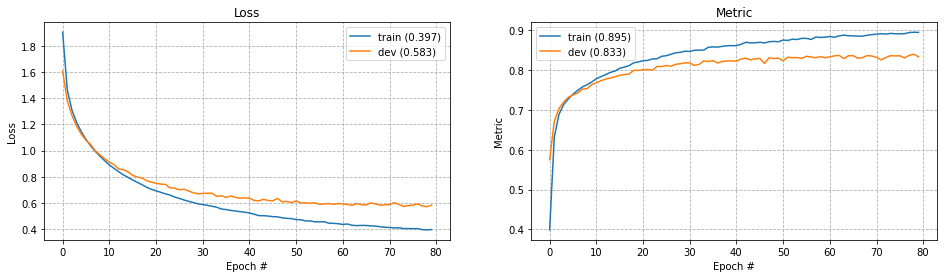

In [16]:
'''
# with scheduler (0.05), with batch_norm, batch_norm_after_activation=True, with reg
# modules cnt = 3
# optim = Adam

'''
train_loader, val_loader = loader.get_data_loaders(batch_size=666, num_workers=0)
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[100],
                 batch_norm=True, 
                 batch_norm_after_activation=True).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.05)



trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device,
              epochs=80)

In [17]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=600)
test_accuracy = trainer.test(test_loader, device, accuracy)
print("Test accuracy: %2.4f" % test_accuracy)

# OH YEAH!

Test accuracy: 0.8170


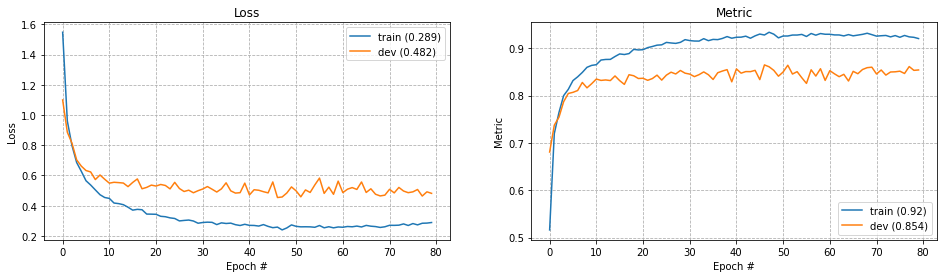

In [25]:
train_loader, val_loader = loader.get_data_loaders(batch_size=666, num_workers=4)
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[300, 1000],
                 batch_norm=True, 
                 batch_norm_after_activation=True).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=3 * 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.05)



trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device,
              epochs=80)

In [26]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=600)
test_accuracy = trainer.test(test_loader, device, accuracy)
print("Test accuracy: %2.4f" % test_accuracy)

# OH YEAH!

Test accuracy: 0.8354


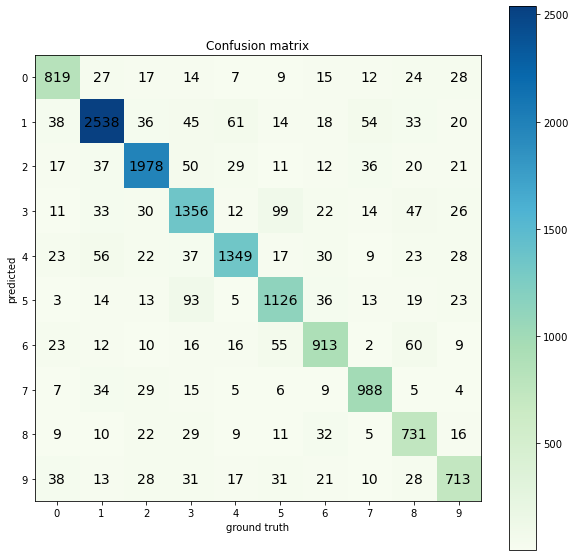

In [27]:
predictions, gt = evaluate_model(nn_model, loader.data_train, loader.val_indices, device)

assert len(predictions) == len(loader.val_indices)
assert len(gt) == len(loader.val_indices)
assert gt[100] == loader.data_train[loader.val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

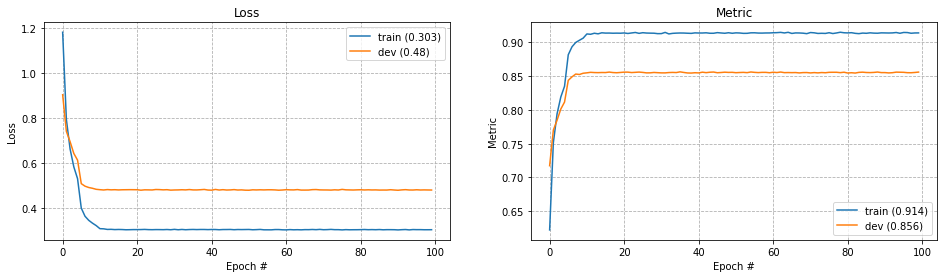

In [8]:
'''
# with scheduler (0.05), with batch_norm, batch_norm_after_activation=True, with reg
# modules cnt = 3
# optim = Adam

'''
train_loader, val_loader = loader.get_data_loaders(batch_size=400, num_workers=4)
nn_model = FCNet(in_features=3*32*32, 
                 n_output=10, 
                 hidden_sizes=[500, 600, 1000],
                 batch_norm=True, 
                 batch_norm_after_activation=True).type(torch.FloatTensor)

trainer = Trainer(nn_model, train_loader, val_loader)

loss_fn = nn.CrossEntropyLoss().type(torch.FloatTensor)
opt = optim.Adam(nn_model.parameters(), lr=0.3 * 1e-3, weight_decay=1e-3)
# opt = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-3, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 11, 12, 13, 15, 17, 19], gamma=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.05)


# how to effectively deal with plateaus :?
trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device,
              scheduler=scheduler,
              epochs=100, 
              plato_epoch=11)

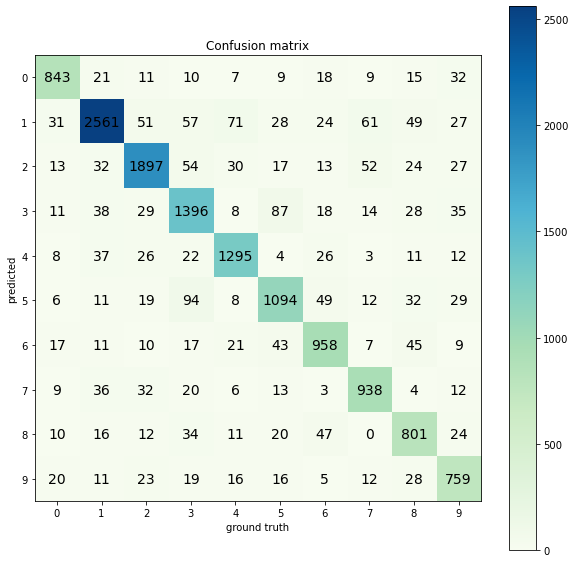

In [12]:
predictions, gt = evaluate_model(nn_model, loader.data_train, loader.val_indices, device)

assert len(predictions) == len(loader.val_indices)
assert len(gt) == len(loader.val_indices)
assert gt[100] == loader.data_train[loader.val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [13]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(loader.data_test, batch_size=64)
test_accuracy = trainer.test(test_loader, device, accuracy)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8301
